<a href="https://colab.research.google.com/github/Seligmann/carvana-image-masking-challenge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!pip install git+https://github.com/tensorflow/examples.git
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import os
import numpy as np
import pathlib
import pandas as pd
import tensorflow_datasets as tfds
from PIL import Image
import cv2
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
import math
import keras.backend as K

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lotqk84e
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-lotqk84e


In [58]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [59]:
import os

# # Upload the API token.
# def get_kaggle_credentials():
#   token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
#   token_file = os.path.join(token_dir, "kaggle.json")
#   if not os.path.isdir(token_dir):
#     os.mkdir(token_dir)
#   try:
#     with open(token_file,'r') as f:
#       pass
#   except IOError as no_file:
#     try:
#       from google.colab import files
#     except ImportError:
#       raise no_file
    
#     uploaded = files.upload()
    
#     if "kaggle.json" not in uploaded:
#       raise ValueError("You need an API key! see: "
#                        "https://github.com/Kaggle/kaggle-api#api-credentials")
#     with open(token_file, "wb") as f:
#       f.write(uploaded["kaggle.json"])
#     os.chmod(token_file, 600)

# get_kaggle_credentials()

In [60]:
# import kaggle

In [61]:
# Download competition data to /content
# !kaggle competitions download -c carvana-image-masking-challenge

In [62]:
metadata_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/metadata.csv'
train_masks_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/train_masks.csv'
train_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train'
train_masks_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks'
test_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/test'

In [63]:
metadata_df = pd.read_csv(metadata_csv)
train_masks_df = pd.read_csv(train_masks_csv)

In [64]:
metadata_df.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [65]:
train_masks_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [66]:
train_files = os.listdir(train_data)
train_mask_files = os.listdir(train_masks_data)
test_files = os.listdir(test_data)
print("Train files count:", len(train_files))
print("Train mask files count:", len(train_mask_files))
print("Test files count:", len(test_files))

Train files count: 5088
Train mask files count: 5088
Test files count: 100064


In [67]:
# Get unique ids for each of the photos in train and test datasets
train_ids = []
for n in train_files:
  train_ids.append(n.split("_")[0])

test_ids = []
for n in test_files:
  test_ids.append(n.split("_")[0])

train_mask_ids = []
for n in train_mask_files:
  train_mask_ids.append(n.split("_")[0])

In [68]:
# Using the training images and their masks, we want to create pairs of 
# NumPy matrices, in order to display each training image and it's mask as 
# images, as well as get their dimensions. We also need to trace an image to
# the path of it's training or testing ID.

# But, not all training images have an associated mask. Each training, test, and
# training mask file has an ID. If some training image has a training mask,
# they will share an id.

# Note: One ID is shared across it's testing, training, and/or mask image set.

# Example format of each file:
# * train_files[0]: 0cdf5b5d0ce1_01.jpg
# * train_mask_files[0]: cf65b1c5e147_09_mask.gif
# * test_files[0]: 3a2e36d7cd6a_01.jpg
# * train_ids[0]: cf65b1c5e147
# * train_mask_ids[0]: cf65b1c5e147
# * test_ids[0]: 0004d4463b50

def GetCarImageFiles(car_image_id, get_mask=False):
  if get_mask:
    if car_image_id in train_mask_ids:
      for n in train_mask_files:
        if car_image_id in n:
          return [train_masks_data + "/" + n]
    else:
      raise Exception("Input image does not have a mask ID")
  elif car_image_id in train_ids:
    for n in train_files:
      if car_image_id in n:
        return [train_data + "/" + n]
  elif car_image_id in test_ids:
    for n in test_files:
      if car_image_id in n:
        return [test_data + "/" + n]
  else:
    raise Exception("No test, train, or mask image with this ID found")

def GetImageMatrix(image_path):
  img = Image.open(image_path)
  return np.asarray(img, dtype=np.uint8)

['/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks/cf65b1c5e147_09_mask.gif']
['/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train/cf65b1c5e147_09.jpg']
Image shape: (1280, 1918, 3)
Image type: uint8
Mask shape: (1280, 1918)
Mask type: uint8


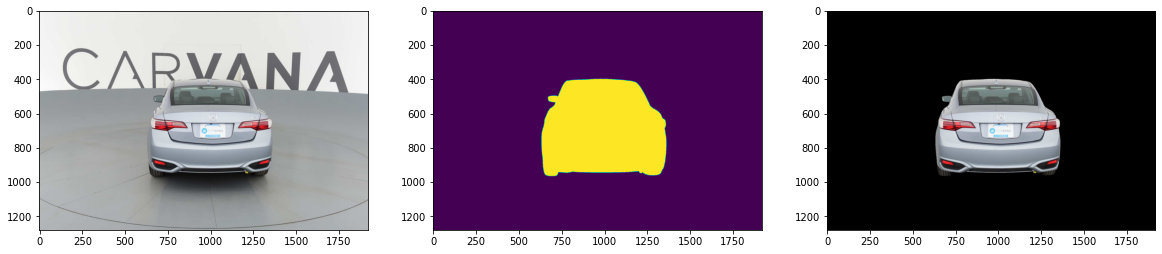

In [69]:
# Display single car with associated mask

# Get image and mask
path_to_mask = GetCarImageFiles(train_ids[0], get_mask=True)
print(path_to_mask)
mask = GetImageMatrix(path_to_mask[0])
path_to_image = GetCarImageFiles(train_ids[0])
print(path_to_image)
image = GetImageMatrix(path_to_image[0])
dest_and = cv2.bitwise_and(image, image, mask=mask)

print("Image shape:", image.shape)
print("Image type:", image.dtype)
print("Mask shape:", mask.shape)
print("Mask type:", mask.dtype)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(dest_and)

### Create dataframe using file paths

In [70]:
def CreateDataframe(img_path, mask_path):

    car_ids = []
    car_paths = []
    mask_ids=[]
    mask_paths=[]
    for p in (img_path,mask_path): 
        for dirname, _, filenames in os.walk(p): 
            for filename in filenames:
                path = os.path.join(dirname, filename)  
                if p==img_path:
                    car_paths.append(path)
                    car_id = filename.split(".")[0]
                    car_ids.append(car_id)
                    df=pd.DataFrame(data = {"id": car_ids, "img_path": car_paths}).set_index('id')
                else:
                    mask_paths.append(path)
                    mask_id = filename.split(".")[0]
                    mask_id = mask_id.split("_mask")[0]
                    mask_ids.append(mask_id)
                    df_mask=pd.DataFrame(data = {"id": mask_ids, "mask_path": mask_paths}).set_index('id')
                    
    df["mask_path"] = df_mask["mask_path"]

    return df

In [71]:
df = CreateDataframe(train_data,train_masks_data)
df.head()

,img_path,mask_path
id,,
cf65b1c5e147_09,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_10,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_11,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_12,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...
cf65b1c5e147_13,/content/drive/MyDrive/MyDrive/carvana-image-m...,/content/drive/MyDrive/MyDrive/carvana-image-m...


In [72]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 5088 entries, cf65b1c5e147_09 to 0789bed99cb8_08
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   5088 non-null   object
 1   mask_path  5088 non-null   object
dtypes: object(2)
memory usage: 119.2+ KB


### Configuration

In [73]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [256,256]
EPOCHS = 1  
SEED = 100
BATCH_SIZE = 32

### Dataset functions

In [74]:
def ReadImageAndMask(image_path, mask_path=None, resize=IMAGE_SIZE):
  # Get a tensor with the entire contents of the input filename
  image = tf.io.read_file(image_path)
  print("JPEG-encoded image:", image)
  # Decode the JPEG-encoded image to a uint8 tensor
  image = tf.image.decode_jpeg(image, channels=3)
  print("JPEG-encoded image -> uint8 tensor", image)
  image = tf.image.resize(image, IMAGE_SIZE)
  image = tf.cast(image, dtype=tf.float32)/255.
  print("final version", image)

  if not mask_path is None:
    mask=tf.io.read_file(mask_path)
    mask=tf.image.decode_jpeg(mask, channels=3)
    mask=mask[:,:,:1]
    mask=tf.image.resize(mask, IMAGE_SIZE)
    mask = tf.cast(mask, dtype=tf.float32)/255.

    return image, mask

  return image

def GetTrainingDataset(df):
  # With each of the image and mask values, create a dataset with a separate 
  # element for each of the input tensor.
  training_dataset = tf.data.Dataset.from_tensor_slices((df["img_path"].values, df["mask_path"].values))
  training_dataset = training_dataset.map(ReadImageAndMask, num_parallel_calls=AUTO)
  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  # Don't have enough data, so just keep repeating until next epoch
  # training_dataset = training_dataset.repeat()
  # Get info for next iteration before current one is finished
  training_dataset = training_dataset.prefetch(AUTO) 

  return training_dataset

def GetValidationDataset(df):
  validation_dataset = tf.data.Dataset.from_tensor_slices((df["img_path"].values, df["mask_path"].values))
  validation_dataset = validation_dataset.map(ReadImageAndMask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)


  return validation_dataset

def GetTestDataset(images):
  test_dataset = tf.data.Dataset.from_tensor_slices((images))
  test_dataset = test_dataset.batch(10, drop_remainder=True)
  
  return test_dataset

tr_df, val_df = train_test_split(CreateDataframe('/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train', '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks'), random_state=SEED, test_size=.25)
print("tr_df", tr_df)
print("val_df", val_df)
tr_dataset = GetTrainingDataset(tr_df)
print("tr_dataset", tr_dataset)
val_dataset = GetTrainingDataset(val_df)
print("val_dataset", val_dataset)

tr_df                                                           img_path                                          mask_path
id                                                                                                                   
c7145a80089e_07  /content/drive/MyDrive/MyDrive/carvana-image-m...  /content/drive/MyDrive/MyDrive/carvana-image-m...
858841907a4a_07  /content/drive/MyDrive/MyDrive/carvana-image-m...  /content/drive/MyDrive/MyDrive/carvana-image-m...
f3eee6348205_11  /content/drive/MyDrive/MyDrive/carvana-image-m...  /content/drive/MyDrive/MyDrive/carvana-image-m...
6d375bc2ece1_01  /content/drive/MyDrive/MyDrive/carvana-image-m...  /content/drive/MyDrive/MyDrive/carvana-image-m...
fdc2c87853ce_07  /content/drive/MyDrive/MyDrive/carvana-image-m...  /content/drive/MyDrive/MyDrive/carvana-image-m...
...                                                            ...                                                ...
0ed6904e1004_14  /content/drive/MyDrive/MyDrive/ca

In [75]:
# Stop training at min loss
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

### Loss function

In [76]:
# Credit:
# https://github.com/shruti-jadon/Semantic-Segmentation-Loss-Functions

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

### Define the model

In [77]:
# Modified U-Net, consisting of an encoder and decoder.
# To learn robust features, and reduce the number of trainable parameters, a
# pretrained model can be used as the encoder

OUTPUT_CHANNELS = 1
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
# For every name within the base_model layer
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [78]:
# Decoder/upsampler 
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [79]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  

    x = last(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

    return model

model = unet_model(1)

### Train the model

In [80]:
steps_per_epoch = len(tr_df)//BATCH_SIZE
history = model.fit(tr_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset, 
                    epochs=1,
                    verbose=1,
                    callbacks=[EarlyStoppingAtMinLoss()])

119/119 [==============================] - 1779s 14s/step - loss: 0.1394 - dice_coef: 0.8606 - binary_accuracy: 0.9391 - val_loss: 0.0483 - val_dice_coef: 0.9517 - val_binary_accuracy: 0.9892


In [81]:
model.evaluate(val_dataset)

40/40 [==============================] - 215s 5s/step - loss: 0.0483 - dice_coef: 0.9517 - binary_accuracy: 0.9892


[0.04833288490772247, 0.9516571760177612, 0.9892042875289917]

In [84]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def vis_compare(dataset=val_dataset,num_case=1):
       
    for sample in dataset.take(1):
        image, label = sample[0].numpy(), sample[1].numpy()
    preds=model.predict(image)
    if num_case>1:
        cases=[j for j in np.random.choice(image.shape[0],size=num_case,replace=False)]    
        for i in cases:
            truth=(image[i],label[i])
            pred=(image[i],preds[i])
            print(f"case_number_{i}")
            display([image[i],label[i],preds[i]])
            print('\n')
            print(464*'*')
            print('\n')
    else:
        truth=(image[0],label[0])
        pred=(image[0],preds[0])
        display([image[0],label[0],preds[0]])
            
    
    
    plt.show()

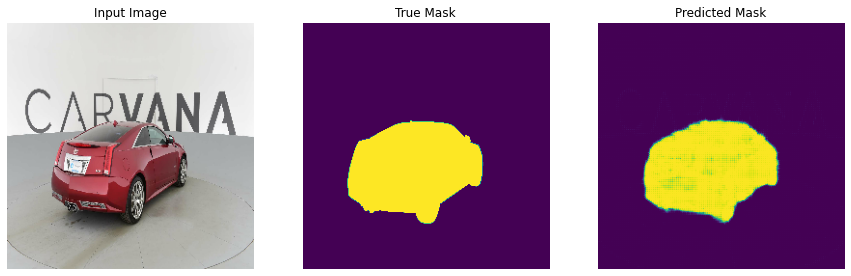

In [85]:
vis_compare(dataset=val_dataset,num_case=1)